In [90]:
movies=read.csv("ml-latest-small/movies.csv")
ratings=read.csv("ml-latest-small/ratings.csv")

In [91]:
head(movies)

,movieId,title,genres
,<int>,<chr>,<chr>
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,2,Jumanji (1995),Adventure|Children|Fantasy
3,3,Grumpier Old Men (1995),Comedy|Romance
4,4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,5,Father of the Bride Part II (1995),Comedy
6,6,Heat (1995),Action|Crime|Thriller


In [92]:
head(ratings)

,userId,movieId,rating,timestamp
,<int>,<int>,<dbl>,<int>
1,1,1,4,964982703
2,1,3,4,964981247
3,1,6,4,964982224
4,1,47,5,964983815
5,1,50,5,964982931
6,1,70,3,964982400


In [93]:
dim(movies)
dim(ratings)

[1] 9742    3

[1] 100836      4

In [94]:
str(movies)
str(ratings)

'data.frame':	9742 obs. of  3 variables:
 $ movieId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ title  : chr  "Toy Story (1995)" "Jumanji (1995)" "Grumpier Old Men (1995)" "Waiting to Exhale (1995)" ...
 $ genres : chr  "Adventure|Animation|Children|Comedy|Fantasy" "Adventure|Children|Fantasy" "Comedy|Romance" "Comedy|Drama|Romance" ...
'data.frame':	100836 obs. of  4 variables:
 $ userId   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ movieId  : int  1 3 6 47 50 70 101 110 151 157 ...
 $ rating   : num  4 4 4 5 5 3 5 4 5 5 ...
 $ timestamp: int  964982703 964981247 964982224 964983815 964982931 964982400 964980868 964982176 964984041 964984100 ...


In [95]:
summary(ratings$rating)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.500   3.000   3.500   3.502   4.000   5.000 

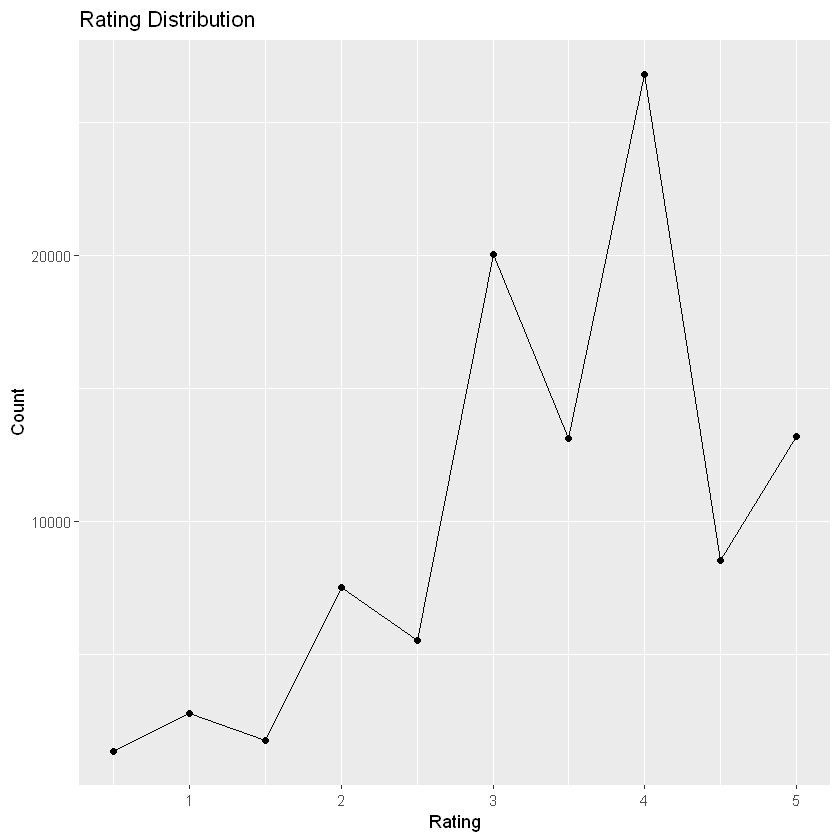

In [96]:
ratings %>% group_by(rating) %>% summarize(count=n())%>% 
    ggplot(aes(x=rating, y=count)) + 
    geom_line() +
    geom_point() +
    ggtitle("Rating Distribution") + 
    xlab("Rating") +
    ylab("Count")

In [97]:
genres_df <- movies %>%
  separate_rows(genres, sep = "\\|") %>%
  group_by(genres) %>%
  summarise(number = n()) %>%
  arrange(desc(number))

print(genres_df)

# A tibble: 20 x 2
   genres             number
   <chr>               <int>
 1 Drama                4361
 2 Comedy               3756
 3 Thriller             1894
 4 Action               1828
 5 Romance              1596
 6 Adventure            1263
 7 Crime                1199
 8 Sci-Fi                980
 9 Horror                978
10 Fantasy               779
11 Children              664
12 Animation             611
13 Mystery               573
14 Documentary           440
15 War                   382
16 Musical               334
17 Western               167
18 IMAX                  158
19 Film-Noir              87
20 (no genres listed)     34


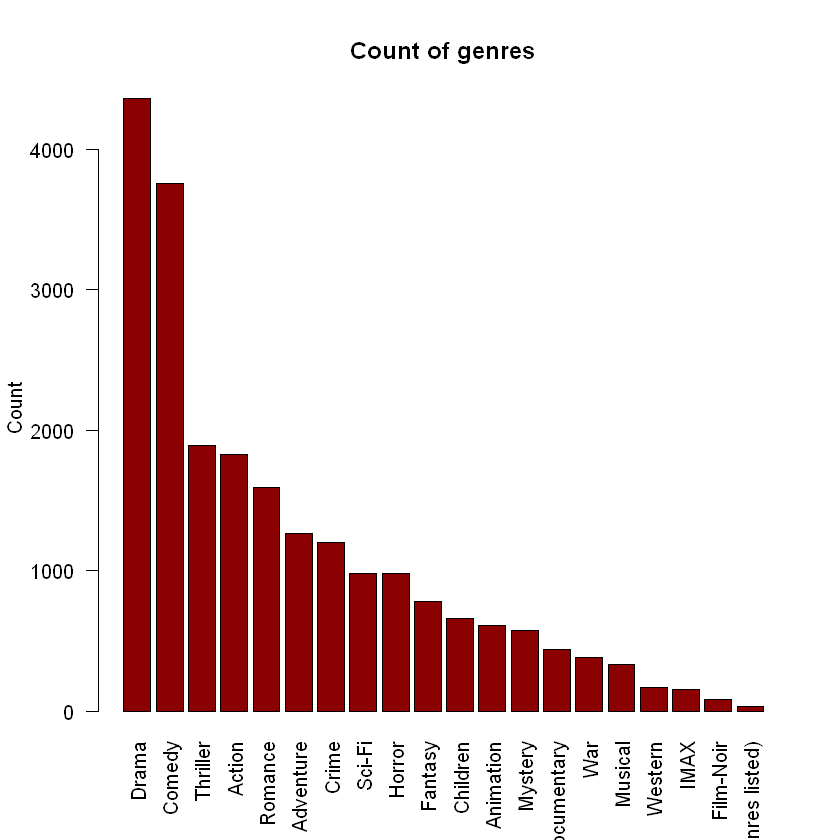

In [98]:
barplot(genres_df$number,
main = "Count of genres",
ylab = "Count",
names.arg = genres_df$genres,
las=2,
col = "darkred")

In [99]:
library(ggplot2)
library(tidyr)
library(stringi)
library(reshape2)
library(recommenderlab)

In [100]:
#Create ratings matrix with rows as users and columns as movies. We don't need timestamp
ratingmat = dcast(ratings, userId~movieId, value.var = "rating", na.rm=FALSE)

#We can now remove user ids
ratingmat = as.matrix(ratingmat[,-1])

In [101]:
#Convert ratings matrix to real rating matrix which makes it dense
ratingmat = as(ratingmat, "realRatingMatrix")

In [102]:
#Normalize the ratings matrix
ratingmat = normalize(ratingmat) 

In [103]:
#Create Recommender. The parameters are UBCF and Cosine similarity. We take 10 nearest neighbours
rec_mod = Recommender(ratingmat, method = "UBCF", param=list(method="cosine",nn=10)) 

In [104]:
eval_sets <- evaluationScheme(data = ratingmat, method = "split",
train = 0.8, given = 19, goodRating = 3)

In [105]:
models <- list(
IBCF_cos = list(name = "IBCF", param = list(method = "cosine")),
IBCF_cor = list(name = "IBCF", param = list(method = "pearson")),
UBCF_cos = list(name = "UBCF", param = list(method = "cosine")),
UBCF_cor = list(name = "UBCF", param = list(method = "pearson"))
)

In [106]:
eval_results <- evaluate(x = eval_sets, method = models, n = 1:19)

IBCF run fold/sample [model time/prediction time]
	 1  [189.25sec/0.45sec] 
IBCF run fold/sample [model time/prediction time]
	 1  [126.27sec/0.36sec] 
UBCF run fold/sample [model time/prediction time]
	 1  [0.01sec/8.21sec] 
UBCF run fold/sample [model time/prediction time]
	 1  [0.02sec/4.18sec] 


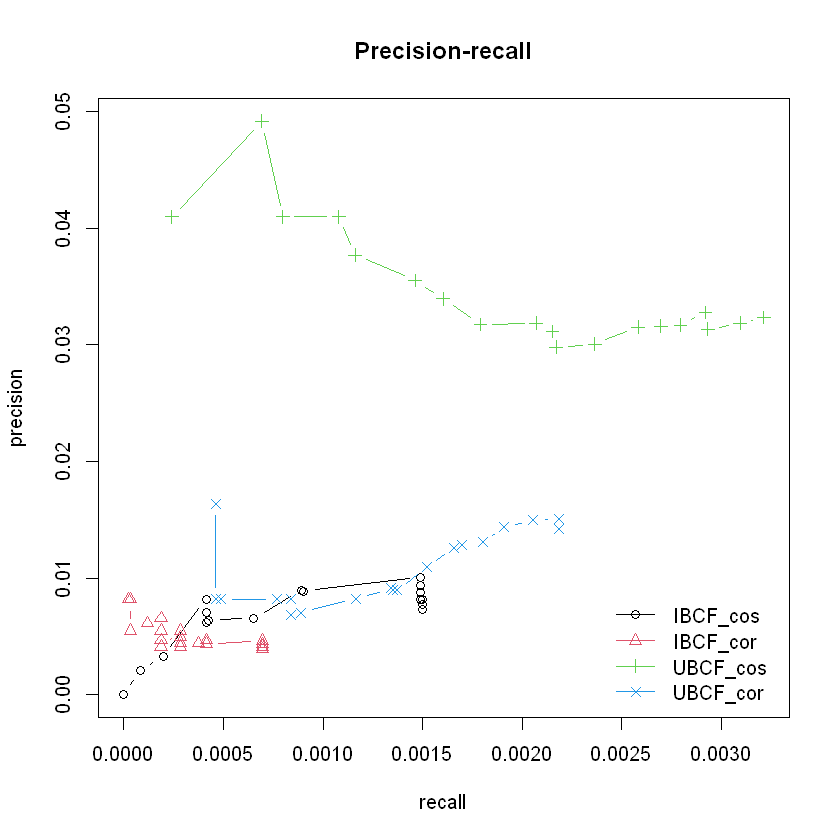

In [112]:
plot(eval_results, "prec/rec", legend = "bottomright") 
title("Precision-recall")

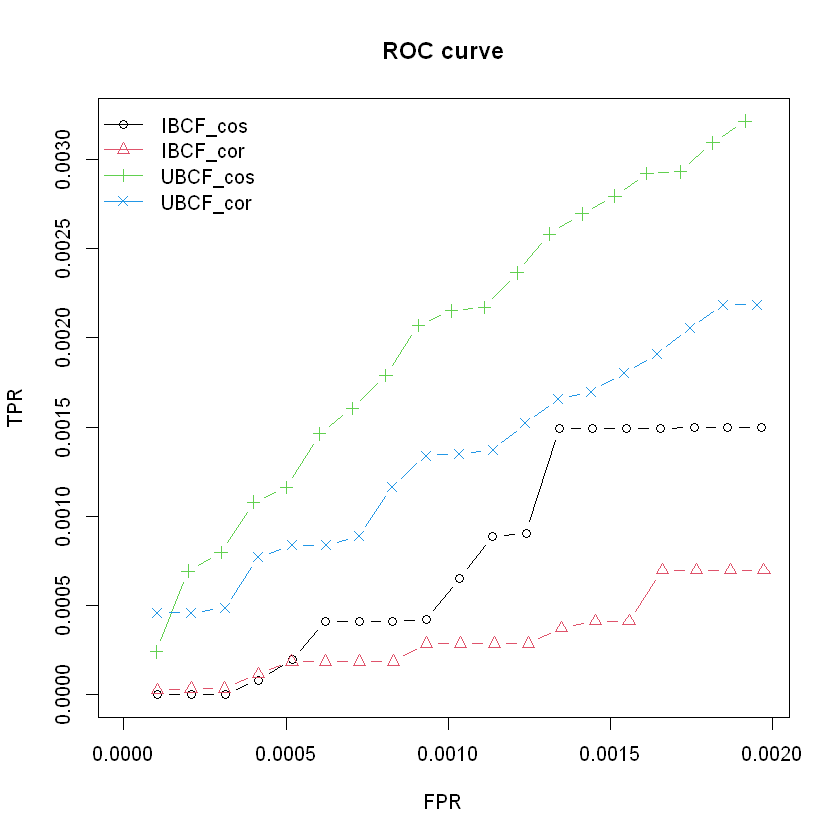

In [113]:
plot(eval_results, legend = "topleft") 
title("ROC curve")

In [107]:
#Obtain top 5 recommendations for 1st user entry in dataset
Top_5_pred = predict(rec_mod, ratingmat[1], n=5)

In [108]:
#Convert the recommendations to a list
Top_5_List = as(Top_5_pred, "list")
Top_5_List

[[1]]
[1] "32"    "30803" "5066"  "42728" "55052"

In [109]:
#We convert the list to a dataframe and change the column name to movieId
Top_5_df=data.frame(Top_5_List)
colnames(Top_5_df)="movieId"

#Since movieId is of type integer in Movies data, we typecast id in our recommendations as well
Top_5_df$movieId=as.numeric(Top_5_df$movieId)

#Merge the movie ids with names to get titles and genres
names=left_join(Top_5_df, movies, by="movieId")

#Print the titles and genres
names

movieId,title,genres
<dbl>,<chr>,<chr>
32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
30803,3-Iron (Bin-jip) (2004),Drama|Romance
5066,"Walk to Remember, A (2002)",Drama|Romance
42728,Tristan & Isolde (2006),Drama|Romance
55052,Atonement (2007),Drama|Romance|War
